# Analisis de cancelacion de clientes para el operador de telecomunicaciones Interconnect

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario(a) planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Tarea 
**Desarrollo del prototipo de un modelo de aprendizaje automatico (machine learning) para pronosticar la cancelacion de contrato de un cliente**

## Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

**1.- Comunicación por teléfono fijo**. El teléfono se puede conectar a varias líneas de manera simultánea.

**2.- Internet**. La red se puede configurar a través de una línea telefónica (DSL, línea de abonado digital) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (ProtecciónDeDispositivo) y un bloqueador de sitios web maliciosos (SeguridadEnLínea).

- Una línea de soporte técnico(SoporteTécnico).

- Almacenamiento de archivos en la nube y backup de datos (BackupOnline).

- Streaming de TV (StreamingTV) y directorio de películas (StreamingPelículas)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica.

## Plan de trabajo inicial para EDA 

Empezaremos por la apertura de los datasets, estos a su vez seran preprocesados para la verificación y correción(en su caso) del tipo de datos, duplicados, y ausentes, ademas, analizaremos el contenido de las tablas asi como sus estadisticos. Seguido de esto realizaremos un  EDA para posteriormente hacer preguntas acerca de nuestro objetivo y un plan de trabajo general para la realización de este.

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Preprocesamiento de los datos

In [1]:
# importar librerias
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc,roc_auc_score, f1_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# Apertura de los archivos 
contract_df = pd.read_csv('contract.csv')
internet_df = pd.read_csv('internet.csv')
personal_df = pd.read_csv('personal.csv')
phone_df = pd.read_csv('phone.csv')

In [5]:
# Tabla de contratos
display(contract_df.info())
display(contract_df.describe())
contract_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


En esta tabla tenemos la información de los contratos de nuestros clientes: la id de cliente, la fecha en que comenzo el contrato, la fecha en que termino el contrato (en caso de que el contrato de usuario sigue activo tenemos 'No'), el tipo de pago(cada cuando se efectua), si tiene facturación electronica, cual es el metodo de pago, el monto mensual y el monto total a pagar. 

Se creara la columna 'Excited' en base a la columna 'EndDate', esta contendra 0 si un cliente es activo y 1 si en cliente ha cancelado

Tenemos el tipo de datos incorrecto en cargo total(TotalCharges) es un string siendo que deberia ser un valor numérico, este se corregira al tipo de dato correcto.

Además tenemos que la fecha de comienzo y finalización del contrato son strings y no DateTime lo cual seria optimo corregir porque asi podemos saber la antiguedad de un cliente y si esta tiene alguna relaci+on con la tasa de cancelación de los clientes.

Se creara la columna 'ContractDuration' que contendra la antiguedad de un cliente en meses, es decir los meses transcurridos entre la fecha de inicio a la fecha de cancelacion, en el caso de no tener fecha de cancelacion se tomara la fecha del 1 de febrero del 2020 la cual es en la que la informacion de los datos se capturo.

In [8]:
# Creacion de la columna 'Exited'
contract_df['Exited'] = np.where(contract_df['EndDate'] == 'No', 0, 1)

In [10]:
# Correcion del tipo de dato en columna 'TotalCharge'
contract_df['TotalCharges'].astype('float')

ValueError: could not convert string to float: ' '

In [12]:
contract_df[contract_df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Tenemos valores ' ' en cargos totales, esto no nos permite la conversion directa a float, al consultar que filas tienen este error podemos ver que tienen la misma fecha de inicio y no tiene de finalizacion, esto puede indicar que son clientes nuevos que tal vez aun no cumplan un mes de antiguedad por lo que se presentan errores al hacer el calculo de los cargos totales, tambien observamos que el tipo de pago es de dos años o uno(en un caso), esto tambien puede ser la razon del error ya que al aun no pasar ese tiempo, no es posible calcular el cargo total.

Debido a que solo son 11 filas de un total de 7043, no representan una parte significativa del total de datos por lo que eliminaremos los registros.

In [15]:
# Eliminacion de filas donde se tenga un espacio vacio en la columna 'totalcharge'
contract_df = contract_df[contract_df['TotalCharges'] != ' ']
# Cambiar tipo de dato 
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float')

C:\Users\jesus\AppData\Local\Temp\ipykernel_16348\1889592782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float')


In [17]:
# Convertir las columnas de fecha a tipo datetime
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors='coerce')  # Converting 'No' to NaT (Not a Time)

# Fecha de referencia
reference_date = pd.to_datetime('2020-02-01')

# Función para calcular los meses transcurridos
def calcular_meses(row):
    if pd.isna(row['EndDate']):  # Si fecha_fin es NaT (por 'No')
        EndDate = reference_date
    else:
        EndDate = row['EndDate']
    
    # Calcular la diferencia en meses
    ContractDuration = (EndDate.year - row['BeginDate'].year) * 12 + EndDate.month - row['BeginDate'].month
    return ContractDuration

# Aplicar la función al DataFrame
contract_df['ContractDuration'] = contract_df.apply(calcular_meses, axis=1)

C:\Users\jesus\AppData\Local\Temp\ipykernel_16348\1395595801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
C:\Users\jesus\AppData\Local\Temp\ipykernel_16348\1395595801.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors='coerce')  # Converting 'No' to NaT (Not a Time)
C:\Users\jesus\AppData\Local\Temp\ipykernel_16348\1395595801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [19]:
# analizar cambios 
display(contract_df.info())
display(contract_df.describe())
display(contract_df.duplicated().sum())
contract_df

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Exited            7032 non-null   int32         
 9   ContractDuration  7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 576.8+ KB


None

,BeginDate,EndDate,MonthlyCharges,TotalCharges,Exited,ContractDuration
count,7032,1869,7032.000000,7032.000000,7032.000000,7032.000000
mean,2017-04-28 23:14:44.641638400,2019-11-15 21:31:18.009630976,64.798208,2283.300441,0.265785,32.421786
min,2013-10-01 00:00:00,2019-10-01 00:00:00,18.250000,18.800000,0.000000,1.000000
25%,2015-06-01 00:00:00,2019-11-01 00:00:00,35.587500,401.450000,0.000000,9.000000
50%,2017-09-01 00:00:00,2019-11-01 00:00:00,70.350000,1397.475000,0.000000,29.000000
75%,2019-04-01 00:00:00,2019-12-01 00:00:00,89.862500,3794.737500,1.000000,55.000000
max,2020-01-01 00:00:00,2020-01-01 00:00:00,118.750000,8684.800000,1.000000,72.000000
std,NaN,NaN,30.085974,2266.771362,0.441782,24.545260


0

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,0,24
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,0,72
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,0,11
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,4


Ahora tenemos una tabla mas completa y en formato correcto, enriquecimos los datos con columnas que nos ayudan a entender mejor el comportamiento de los clientes que cancelaron y lo que no. Ahora las estadisticas nos brindan una vision mas completa sobre los datos.

In [22]:
display(personal_df.info())
display(personal_df.describe())
display(personal_df.duplicated().sum())
personal_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


0

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Tenemos la tabla personal con la informacion de todos los clientes, su genero, si es jubilado, si tiene pareja y si tiene algun familiar dependiente, esta en los formatos correctos aunque tenemos variables categoricas donde en una columna tenemos 0 y 1  y en otra 'Yes' y 'No'. Para uniformidad remplasaremos los valores 0 y 1 en la columna 'SeniorCitizen' por 'No' y 'Yes' respectivamente.

In [25]:
# Correcion a object en 'seniorcitizen' de la tabla personal
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].replace({0: 'No', 1 : 'Yes'})
display(personal_df.dtypes)
print()
print( 'Valores en la columna SeniorCitizen',personal_df['SeniorCitizen'].unique())

customerID       object
gender           object
SeniorCitizen    object
Partner          object
Dependents       object
dtype: object


Valores en la columna SeniorCitizen ['No' 'Yes']


In [27]:
display(internet_df.info())
display(internet_df.describe())
display(internet_df.duplicated().sum())
internet_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


0

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Tenemos informacion de los clientes que tienen contrato de internet y ademas otros servicios, podemos ver que hay mas usuarios que usan Fibra optica para su servicio de internet, y tenemos mas usuarios que no tienen contradados los servicios adicionales, rondando un conteo entre 2800 a 3500 de un total de 5517 para cada uno.
No tenemos el total de 7043 filas(como en la tabla personal) lo que nos dice que hay clientes que no tienen un servicio de internet contratado

In [30]:
display(phone_df.info())
display(phone_df.describe())
display(phone_df.duplicated().sum())
phone_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


0

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Tenemos la informacion de los clientes que tienen linea telefonica y si esta es multilinea o no, la moda es 'No',teniendo un conteo de 3390 de un total de 6361, realmente no es significativamente superior a comparacióon del conteo para 'Si'.
De igual modo, no tenemos el total de 7043 filas(como en la tabla personal) lo que nos dice que hay clientes que no tienen un servicio de comunicacion por telefono fijo contratado.

## EDA 

Realizaremos diversos graficos buscando ciertos patrones que ayuden a entender a los clientes, por ejemplo, si hay patrones en aquellos clientes que cancelaron en comparación con los que no. Observaremos principalmente en base a este criterio.

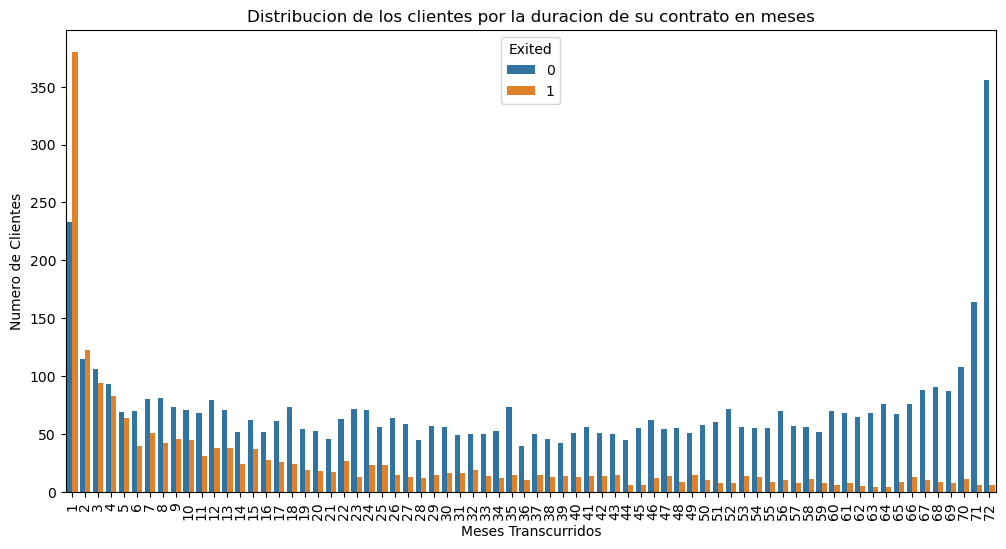

In [34]:
# dataframe para la creacion del grafico
dist_graf_1 = contract_df.groupby([ 'Exited','ContractDuration'])['customerID'].count().reset_index()
# GRafico distribucion por antiguedad
plt.figure(figsize=(12, 6))
sns.barplot(data= dist_graf_1, x= 'ContractDuration', y= 'customerID',hue='Exited')
plt.title('Distribucion de los clientes por la duracion de su contrato en meses')
plt.xlabel('Meses Transcurridos')
plt.ylabel('Numero de Clientes')
plt.xticks(rotation=90)
plt.show()

Tenemos la distribucion de los clientes por los meses transcurridos desde que comenzaron su contrato, diferenciando aquellos que cancelaron su contrato de los que no. Podemos ver que en el caso de las personas que si cancelaron, existe una mayor densidad entre 1 a 12 meses aproximadamente, inferimos que mayormente las personas que cancelaron lo hicieron durante los primeros meses ; el mayor numero de cancelaciones se dio en el primer mes transcurrido del contrato del cliente, siendo de 380, y, conforme el numero de meses aumentaba, el numero de cancelaciones tendia a disminuir.

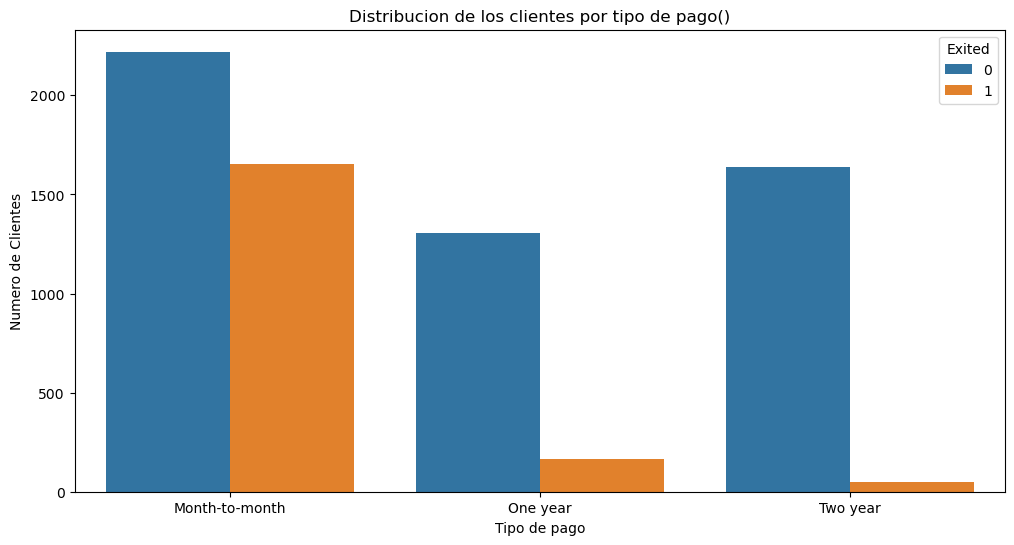

In [36]:
# dataframe para la creacion del grafico
dist_graf_2 = contract_df.groupby([ 'Exited','Type'])['customerID'].count().reset_index()
# GRafico distribucion por antiguedad
plt.figure(figsize=(12, 6))
sns.barplot(data= dist_graf_2, x= 'Type', y= 'customerID',hue='Exited')
plt.title('Distribucion de los clientes por tipo de pago()')
plt.xlabel('Tipo de pago')
plt.ylabel('Numero de Clientes')
plt.show()

Podemos observar que el tipo de pago preferido de los clientes es de mes con mes, teniendo un mayor conteo total de clientes para este metodo, del mismo modo, la mayoria de clientes que cancelaron tenian este tipo de pago, esto es de esperarse dado que en el grafico anterior observamos que la mayor parte de los clientes que cancelaron lo hicieron en los primeros meses.

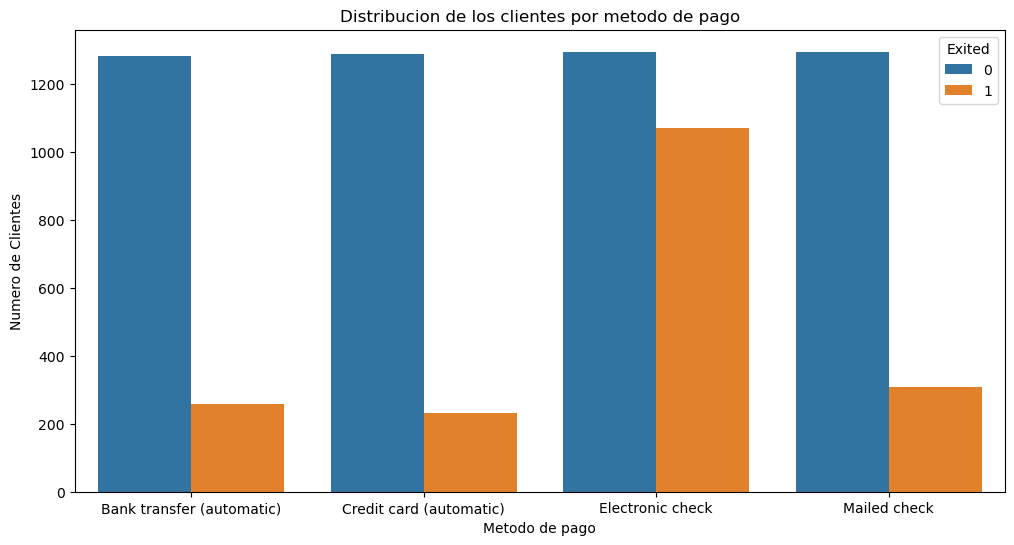

In [38]:
# datframe para la creacion del grafico
dist_graf_3 = contract_df.groupby(['PaymentMethod', 'Exited'])['customerID'].count().reset_index()
# grafico
plt.figure(figsize=(12, 6))
sns.barplot(data= dist_graf_3, x= 'PaymentMethod', y= 'customerID',hue='Exited')
plt.title('Distribucion de los clientes por metodo de pago')
plt.xlabel('Metodo de pago')
plt.ylabel('Numero de Clientes')
plt.show()

No hay un metodo de pago preferido para los clientes que no cancelaron el contrato, se distribuyen de forma muy similar, pero, para el caso de los clientes que si cancelaron, estos mayormente preferian el metodo de pago por cheque electronico.

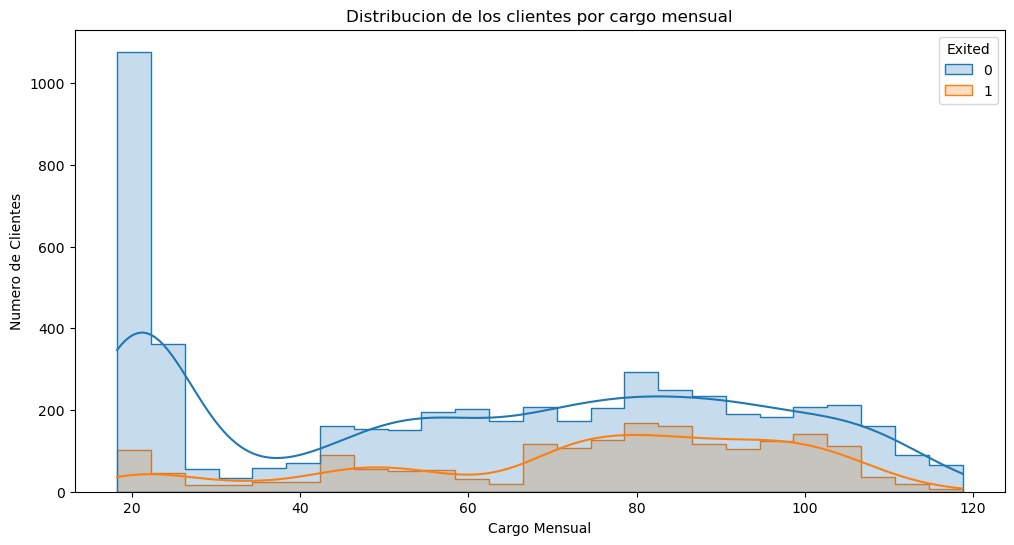

In [40]:
#grafico
plt.figure(figsize=(12, 6))
sns.histplot(data= contract_df, x= 'MonthlyCharges', element='step', hue='Exited', bins=25, kde=True)
plt.title('Distribucion de los clientes por cargo mensual')
plt.xlabel('Cargo Mensual')
plt.ylabel('Numero de Clientes')
plt.show()

Tenemos la distribucion de los clientes por el cargo mensual que pagaban, vemos que para los clientes que no cancelaron existe un pico de alrededor de 1500 personas que su cargo mesual era de 0 a 30 aproximadamente, tambien tenemos una distribucion mas uniforme que dificilmente supera los 200 clientes(en cada intervalo) que tienen un cargo mesual de de 40  a 110.

Para los clientes que si cancelaron, que son significativamente menos que los que no, tenemos una mayor parte de clientes que su cargo mesual es de 70 a 110 aproximadamente, esto puede influir en la naturaleza del porque un cliente cancela, puede que este perciba o considere que esta pagando "de mas" por un algun servicio o varios de estos.

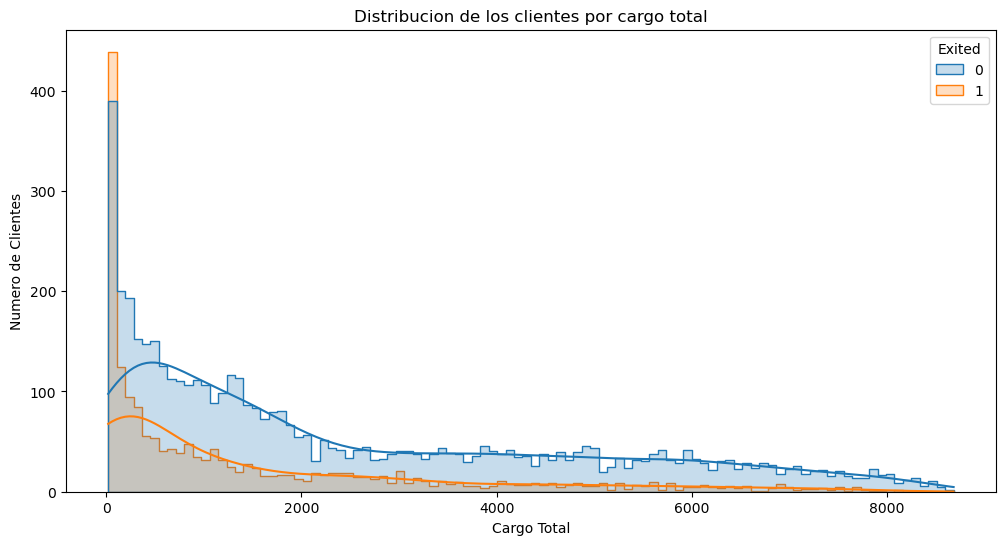

In [42]:
#grafico
plt.figure(figsize=(12, 6))
sns.histplot(data= contract_df, x= 'TotalCharges', element='step', hue='Exited', bins=100, kde=True)
plt.title('Distribucion de los clientes por cargo total')
plt.xlabel('Cargo Total')
plt.ylabel('Numero de Clientes')
plt.show()

Podemos ver como se distribuye el cargo total en la poblacion de los clientes, podemos ver una mayor densidad de clientes que cancelaron en el rango de 0 a 1700 aprox, dependiendo en base a que se calcule la columna 'totalcharges' esto nos podria indicar distintas cosas. Si suponiendo que puede calcularse en base a la suma del monto mensual  de todos los meses que duro el contrato; la mayor parte de los clientes que cancelaron lo hicieron en los primeros meses antes de 1 año, debido a esto, tenemos una mayor parte de la poblacion en ese rango, porque no se acumularon los cargos durante el suficiente tiempo como para que alcanzaran rangos mayores.

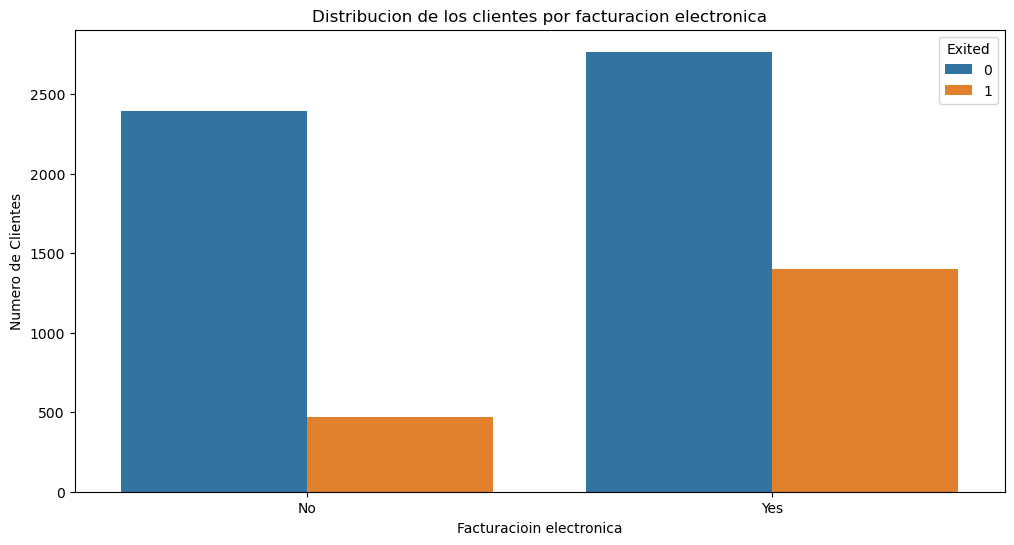

In [44]:
# datframe para la creacion del grafico
dist_graf_4 = contract_df.groupby(['PaperlessBilling', 'Exited'])['customerID'].count().reset_index()
# grafico
plt.figure(figsize=(12, 6))
sns.barplot(data= dist_graf_4, x= 'PaperlessBilling', y= 'customerID',hue='Exited')
plt.title('Distribucion de los clientes por facturacion electronica')
plt.xlabel('Facturacioin electronica')
plt.ylabel('Numero de Clientes')
plt.show()

Existe una mayor cantidad de personas que si tenian la facturacion electronica y cancelaron, en comparacion de los que no la tenian y cancelaron, para los que no cancelaron, no existe una diferencia muy significativa entre los que tenian y no la facturacion electronica.

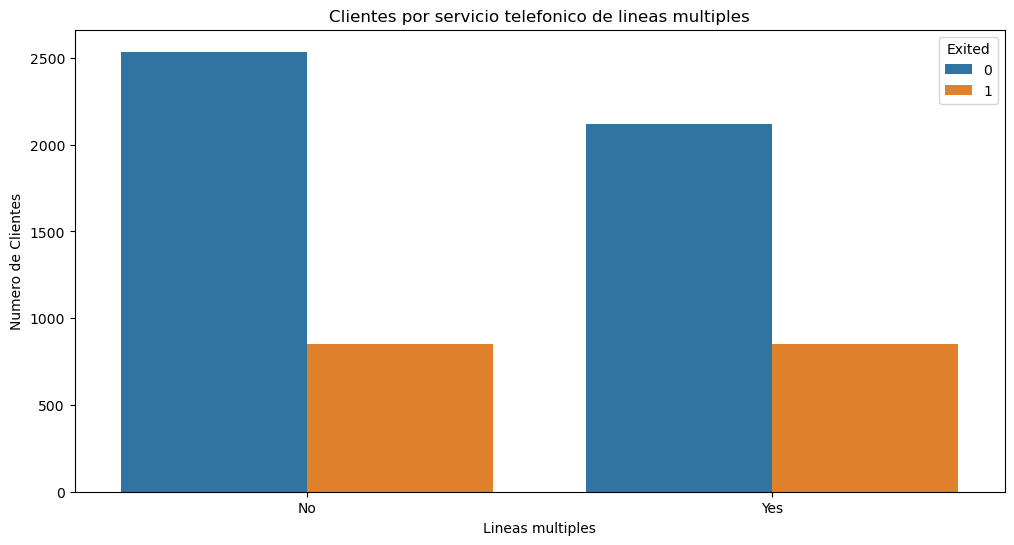

In [46]:
# datframe para la creacion del grafico
df_graf_5 = phone_df.merge(contract_df[['Exited', 'customerID']], how='inner', on='customerID')
# grafico
plt.figure(figsize=(12, 6))
graf_5 = df_graf_5.groupby(['MultipleLines', 'Exited'])['customerID'].count().reset_index()
sns.barplot(data= graf_5, x= 'MultipleLines', y= 'customerID',hue='Exited')
plt.title('Clientes por servicio telefonico de lineas multiples')
plt.xlabel('Lineas multiples')
plt.ylabel('Numero de Clientes')
plt.show()

Para los clientes que cancelaron, no tenemos diferencia significativa en base a si tenian lineas multiples o no, y para los clientes que no cancelaron, existe una mayor cantidad de clientes que no tienen lineas multiples en comparacio con los que si, siendo mayor aproximadamente por 400 clientes.

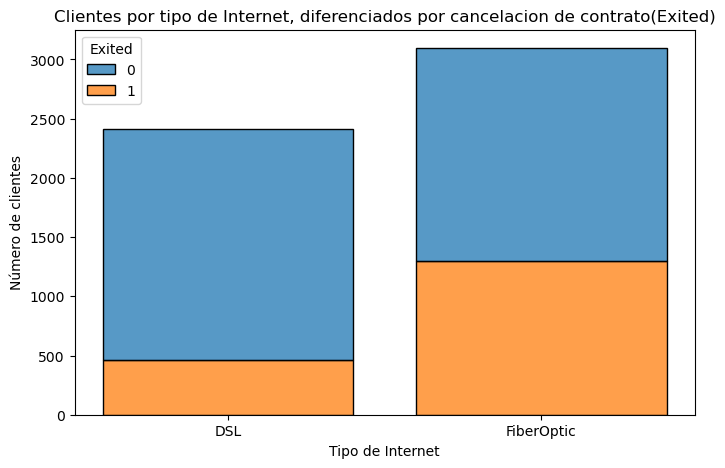

In [48]:
# dataframe para la creacion del grafico
df_graf_6 = internet_df.merge(contract_df[['Exited', 'customerID']], how='inner', on='customerID')
df_graf_6[['DSL', 'FiberOptic']] = pd.get_dummies(df_graf_6['InternetService'], dtype=int)
df_melted_2 = df_graf_6.melt(id_vars=['Exited'],
                             value_vars=['DSL', 'FiberOptic'], 
                             var_name='InternetServiceType', 
                             value_name='HasService'
)

# Filtrar solo clientes que tienen un servicio (HasService == 1)
df_filtered_2 = df_melted_2[df_melted_2['HasService'] == 1]

# Crear el gráfico de barras apiladas
plt.figure(figsize=(8, 5))
sns.histplot(data=df_filtered_2, x='InternetServiceType', hue='Exited', multiple='stack', shrink=0.8, discrete=True)
plt.title('Clientes por tipo de Internet, diferenciados por cancelacion de contrato(Exited)')
plt.xlabel('Tipo de Internet')
plt.ylabel('Número de clientes')
plt.show()

Tenemos mas clientes que tienen fibra optica(3100 aprox) en comparacion de DSl(2500 aprox), pero proporcionalmente, el servicio de internet por DSL tiene menor numero de cancelaciones(500 aprox) en comparacion de la fibra optica(1300 aprox), siendo las cancelaciones para DLS de alrededor del 20% y para la fibra optica alrededor del 42%; el servicio de fibra optica tiene una mayor tasa de cancelacion.

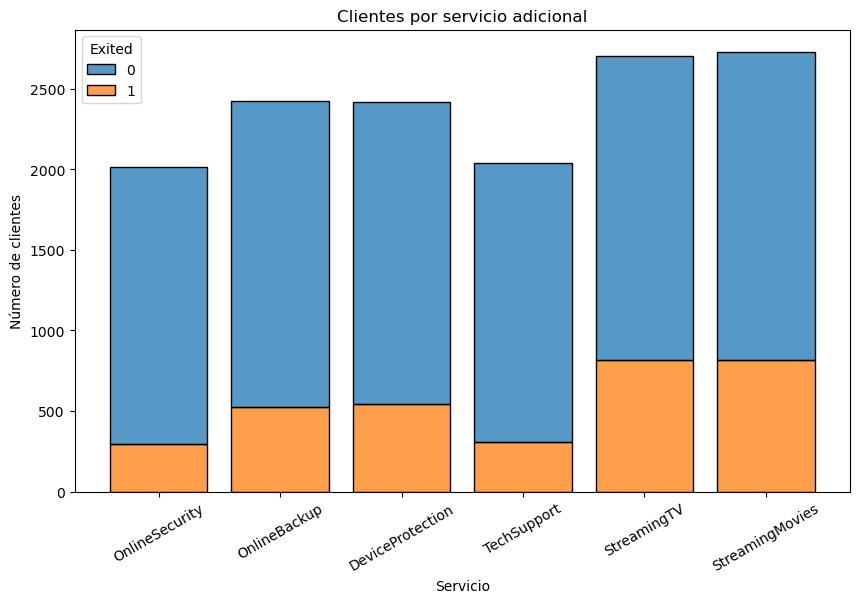

In [51]:
# columnas de servicios adicionales
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
# dataframe para la creacion del grafico
df_melted = df_graf_6.melt(id_vars=['Exited'], value_vars=services, var_name='Service', value_name='HasService')
# Convertir 'Yes' en 1 y 'No' en 0
df_melted['HasService'] = df_melted['HasService'].map({'Yes': 1, 'No': 0})

# Filtrar solo los clientes que tienen el servicio (HasService == 1)
df_filtered = df_melted[df_melted['HasService'] == 1]

# gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='Service', hue='Exited', multiple='stack', shrink=0.8, discrete=True)

# Personalizar el gráfico
plt.title('Clientes por servicio adicional')
plt.xlabel('Servicio')
plt.ylabel('Número de clientes')
plt.xticks(rotation=30)
plt.show()


Podemos ver el numero de clientes por cada servicio diferenciando por quienes cancelaron, los servios de streamingTV y streamingMovies son los mas populares, teniendo una mayor cantidad de clientes, seguidos sin tanta diferencia por OnlineBackup y DeviceProtection.

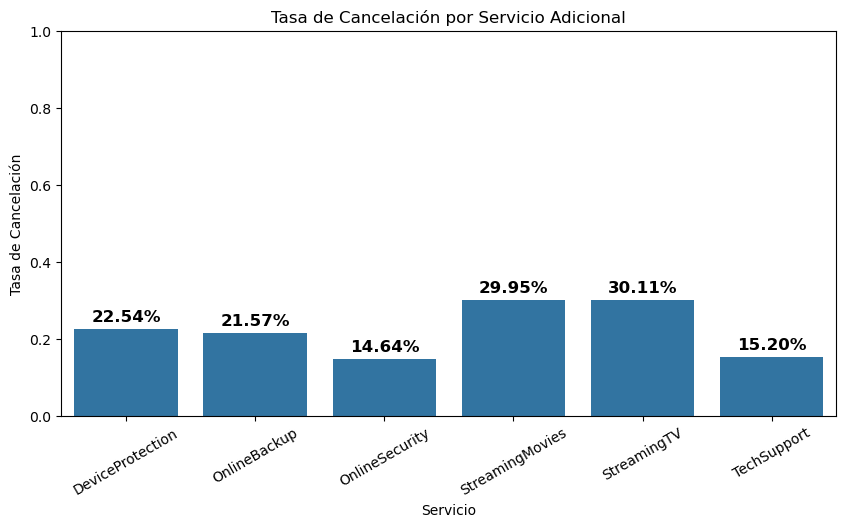

In [54]:
# dataframe para la creacion del grafico
df_service_exit = df_filtered.groupby(['Service', 'Exited'])['HasService'].sum().reset_index()
cancel_rate = df_service_exit[df_service_exit['Exited'] == 1].set_index('Service')['HasService'] / \
              df_service_exit.groupby('Service')['HasService'].sum()

# grafico
plt.figure(figsize=(10, 5))
sns.barplot(x=cancel_rate.index, y=cancel_rate.values)

# Personalización del gráfico
plt.title('Tasa de Cancelación por Servicio Adicional')
plt.xlabel('Servicio')
plt.ylabel('Tasa de Cancelación')
plt.xticks(rotation=30)
plt.ylim(0, 1)
for i, value in enumerate(cancel_rate.values):
    plt.text(i, value + 0.02, f"{value:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.show()

Tenemos la tasa de cancelacion de cada servicio, y vemos que aunque los servicios de StreamingMovies y StreamingTV son los mas populares con una mayor clientela, estos tambien son los que mayor tasa de cancelacion presentan, siendo de alrededor del 30%.

### Conclusiones generales del EDA

El análisis revela varios patrones clave en la cancelación de contratos por parte de los clientes. Tales como

**Cancelaciones tempranas en el contrato:** La mayoría de las cancelaciones ocurren dentro del primer año, con un pico significativo en el primer mes (380 cancelaciones). Esto sugiere que los clientes rápidamente determinan si el servicio cumple con sus expectativas.La tendencia de cancelación disminuye con el tiempo, lo que indica que si un cliente supera los primeros meses, es más probable que permanezca en el servicio.

**Impacto del tipo de pago:** Los clientes que pagan mes a mes tienen la mayor tasa de cancelación. Esto sugiere que los contratos a largo plazo pueden influenciar en no cancelar.El cheque electrónico es el método de pago más común entre los clientes que cancelan.

**Influencia del costo mensual y total:** Los clientes que cancelan tienden a pagar cargos mensuales más altos (70-110), lo que sugiere que el precio puede ser un factor que influye en la decisión de cancelar. La mayoría de los clientes que cancelaron tenían un cargo total acumulado bajo (0 a 1700), lo que refuerza la hipótesis de que abandonaron el servicio en los primeros meses, antes de acumular pagos altos.

**Servicios contratados y su relación con la cancelación:** La fibra óptica tiene una mayor tasa de cancelación (42%) en comparación con DSL (20%).

**Servicios de streaming (StreamingTV y StreamingMovies):** son los más populares, pero también presentan las mayores tasas de cancelación (~30%). Esto sugiere que, aunque son atractivos, pueden no ser un factor de retención fuerte.


## Preguntas aclaratorias

1.- ¿Los servicios cuentan con paquetes? Es decir, con paquetes los cuales tengan distintas caracteristicas tal como mayor velocidad de internet, consumo total de datos de internet distinto, numero de llamadas y/o minutos de llamada.

2.- ¿Cual es el costo base de cada servicio?

3.-¿En base a que se calcula el cargo mensual y total de los clientes?

4.-¿Hay algun limite de consumo o uso de los servicios?,y en caso de haberlo, ¿Excederlo trae un cargo adicional? 

Estas preguntas se hacen con el fin de conocer mas los servicios ofrecidos y el comportamiento de los usuarios,  esto nos ayudaria a identificar los principales factores que influyen en la cancelacion del contrato de servicio por el cliente.

## Paso 1 : Preprocesamiento de los datos para entrenamiento del modelo

Crearemos un dataset con toda la informacion clave, imputaremos valores ausentes y eliminaremos las columnas que no tengan relevancia.

## Plan de Trabajo

A continuacion se enlistan una serie de pasos que serviran de guia en la resolucion de la tarea asignada:

- **Tarea:  Desarrollo del prototipo de un modelo de aprendizaje automatico(machine learning) para pronosticar la cancelacion de contrato de un cliente**

**1.- Preprocesamiento de los datos** 

Se creara un dataframe con todos los datos relevantes para el modelo; se limpiaran los datos, corregiran errores, imputaran valores ausentes en el caso de haberlos.

**2.- Ingenieria de caracteristicas**

Se hara ingenieria de caracteristicas(feature engineering) al dataframe obtenido; One-Hot-Encoding, normalizacion de variables continuas(de ser necesario). Ademas separaremos los conjuntos de entrenamiento, validacion y prueba.

**3.- Seleccion de modelos y busqueda de mejor hiperparametros**

Se seleccionaran algunos modelos de clasificacion y se buscara la combinacion de hiperparametros con el mejor rendimiento evaluando con AUC-ROC y F1 score

**4.- Evaluacion de modelo**

Con los mejores hiperparametros, se seleccionara al modelo que tenga el mejor desempeño, estos se evaluaran principalmente por AUC-ROC, pero ademas consideremos otras metricas.

**5.- Conclusiones**

Se emitira una conclusion del proyecto con insights clave encontradas en su desarrollo asi como sugerencias.

In [64]:
# Unir dataframe contract con personal
data_full = contract_df.merge(personal_df, how= 'inner', on='customerID')
display(data_full.info())
data_full

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Exited            7032 non-null   int32         
 9   ContractDuration  7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   object        
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
dtypes: datetime64[ns](2), fl

None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,Female,No,Yes,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34,Male,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,Male,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,Male,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,Female,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,0,24,Male,No,Yes,Yes
7028,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,0,72,Female,No,Yes,Yes
7029,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,Female,No,Yes,Yes
7030,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,Male,Yes,Yes,No


In [70]:
# Unir dataframe internet con phone con outer para incluir todos los clientes
internet_phone = internet_df.merge(phone_df, how='outer', on='customerID')
display(internet_phone.info())
internet_phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   MultipleLines     6361 non-null   object
dtypes: object(9)
memory usage: 495.3+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,Fiber optic,No,No,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,DSL,Yes,No,No,Yes,No,No,No
7039,9992-RRAMN,Fiber optic,No,No,No,No,No,Yes,Yes
7040,9992-UJOEL,DSL,No,Yes,No,No,No,No,No
7041,9993-LHIEB,DSL,Yes,No,Yes,Yes,No,Yes,No


In [72]:
# Imputar valores ausentes: 'no' para el internet y los demas servicios
internet_phone.fillna('No', inplace=True)
display(internet_phone.info())
internet_phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   InternetService   7043 non-null   object
 2   OnlineSecurity    7043 non-null   object
 3   OnlineBackup      7043 non-null   object
 4   DeviceProtection  7043 non-null   object
 5   TechSupport       7043 non-null   object
 6   StreamingTV       7043 non-null   object
 7   StreamingMovies   7043 non-null   object
 8   MultipleLines     7043 non-null   object
dtypes: object(9)
memory usage: 495.3+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,Fiber optic,No,No,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,DSL,Yes,No,No,Yes,No,No,No
7039,9992-RRAMN,Fiber optic,No,No,No,No,No,Yes,Yes
7040,9992-UJOEL,DSL,No,Yes,No,No,No,No,No
7041,9993-LHIEB,DSL,Yes,No,Yes,Yes,No,Yes,No


In [74]:
# Comprobar los valores en cada columna despues de la imputacion
display(internet_phone['InternetService'].unique())
internet_phone['MultipleLines'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

In [76]:
# Unir los datrafames creados para tener todos los datos en un solo dataframe en baso a customerID
all_data = data_full.merge(internet_phone, how='inner', on='customerID')
display(all_data.info())
all_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Exited            7032 non-null   int32         
 9   ContractDuration  7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   object        
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  InternetService   7032 n

None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,...,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,0,24,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7028,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,0,72,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7029,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,...,Yes,Yes,DSL,Yes,No,No,No,No,No,No
7030,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [78]:
# Eliminacion de columnas irrelevantes para el modelo
all_data.drop(['customerID','BeginDate','EndDate','gender'], axis=1, inplace=True)
all_data

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,No,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.95,1889.50,0,34,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,No,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,One year,Yes,Mailed check,84.80,1990.50,0,24,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7028,One year,Yes,Credit card (automatic),103.20,7362.90,0,72,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7029,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,No,Yes,Yes,DSL,Yes,No,No,No,No,No,No
7030,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


Con nuestro dataframe con todos los dato limpios, organizados y listos, procederemos al siguiente paso

## Paso 2 : Ingenieria de caracteristicas

Aplicaremos One-HOT-Encoding a nuestro dataframe y analizaremos la existencia de desbalance de clases y como solucionarlo.

In [83]:
# Aplicar one-hot-encoding
data_encoded = pd.get_dummies(all_data, drop_first = True)
display(data_encoded.info())
data_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   Exited                                 7032 non-null   int32  
 3   ContractDuration                       7032 non-null   int64  
 4   Type_One year                          7032 non-null   bool   
 5   Type_Two year                          7032 non-null   bool   
 6   PaperlessBilling_Yes                   7032 non-null   bool   
 7   PaymentMethod_Credit card (automatic)  7032 non-null   bool   
 8   PaymentMethod_Electronic check         7032 non-null   bool   
 9   PaymentMethod_Mailed check             7032 non-null   bool   
 10  SeniorCitizen_Yes                      7032 non-null   bool   
 11  Part

None

,MonthlyCharges,TotalCharges,Exited,ContractDuration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,1,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1,56.95,1889.50,0,34,True,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
2,53.85,108.15,1,2,False,False,True,False,False,True,...,False,False,False,True,True,False,False,False,False,False
3,42.30,1840.75,0,45,True,False,False,False,False,False,...,False,False,False,True,False,True,True,False,False,False
4,70.70,151.65,1,2,False,False,True,False,True,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1990.50,0,24,True,False,True,False,False,True,...,True,False,False,True,False,True,True,True,True,True
7028,103.20,7362.90,0,72,True,False,True,True,False,False,...,True,True,False,False,True,True,False,True,True,True
7029,29.60,346.45,0,11,False,False,True,False,True,False,...,True,False,False,True,False,False,False,False,False,False
7030,74.40,306.60,1,4,False,False,True,False,False,True,...,False,True,False,False,False,False,False,False,False,True


Tenemos nuestro dataframe listo con OHE. Ahora analizaremos el desbalance de clases

In [86]:
# Conteo de clases
data_encoded['Exited'].value_counts()

Exited
0    5163
1    1869
Name: count, dtype: int64

Tenemos un desbalance de clases significativo, siendo para la clase positiva un total de 1869 obersvaciones y para la negativa 5163. Si entrenaramos los modelos con este desbalance, estos aprenderian mejor a predecir la clase negativa,en nuestra tarea asignada nos interesa predecir la clase positiva y disminuir los Falsos Negativos (Que el modelo prediga que un cliente no cancelara y que este realmente si lo haga).

Primeramente ajustaremos los pesos de las clases a "balanceado" en cada modelo, ademas implementaremos SMOTE(Synthetic Minority Over-sampling Technique), consideramos que generar datos sinteticos de la clase minoritaria aportaria mas al modelo ya que este no solo duplica los datos, SMOTE puede replicar outliers si no los eliminamos, por lo que analizaremos estos y se ajustara el rango para eliminarlos sin perder tantos datos.


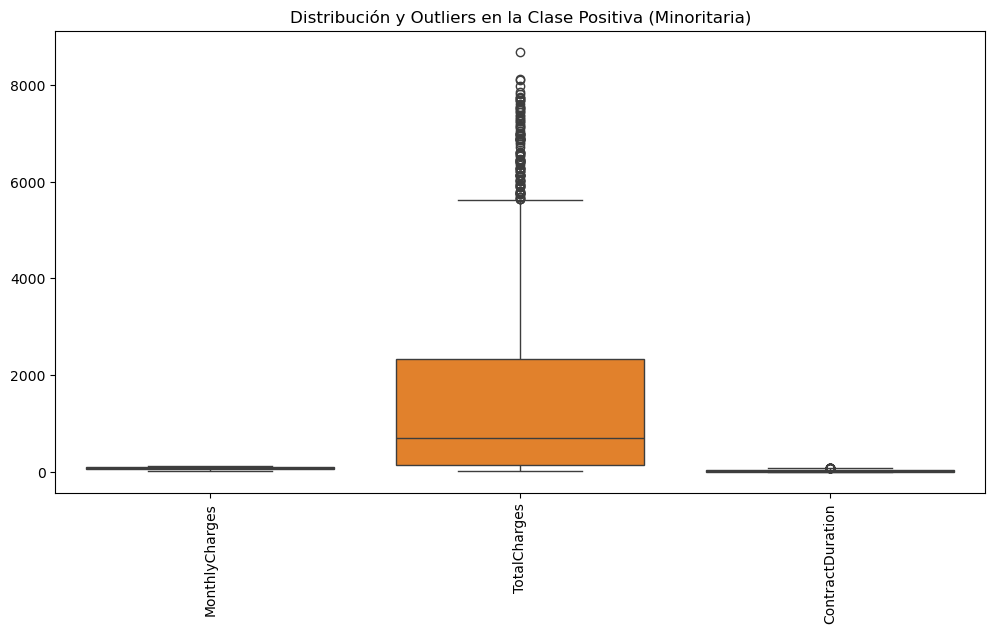

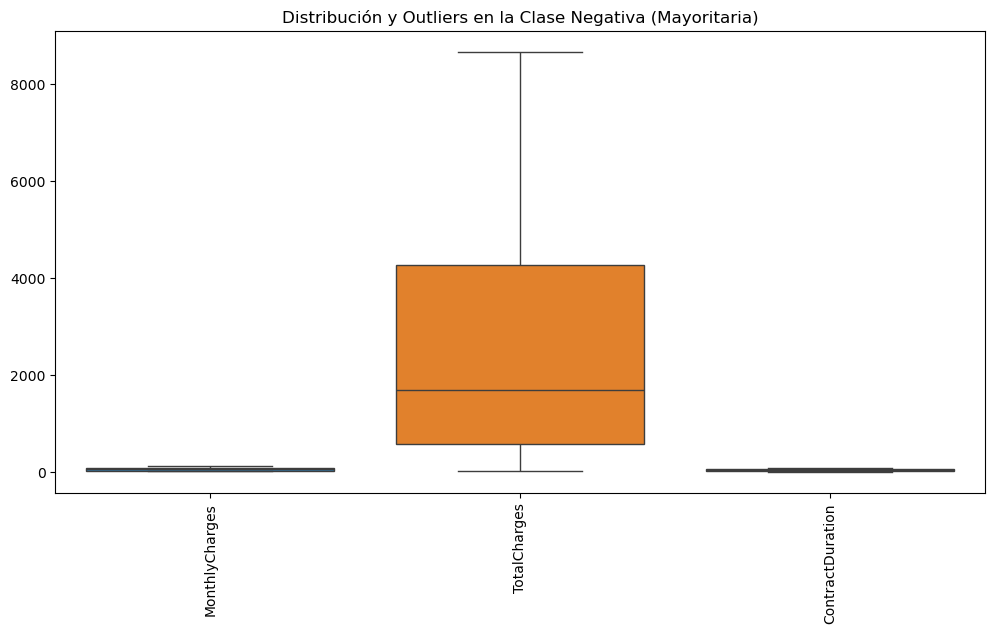

In [89]:
# Lista de columnas numericas
num_cols = ["MonthlyCharges", "TotalCharges", "ContractDuration"]
# Filtrar solo la clase minoritaria
minority_class = data_encoded[data_encoded["Exited"] == 1]
# Filtrar solo la clase mayoritaria
majority_class = data_encoded[data_encoded["Exited"] == 0]

# Visualizar distribución con Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=minority_class[num_cols])
plt.xticks(rotation=90)
plt.title("Distribución y Outliers en la Clase Positiva (Minoritaria)")

plt.figure(figsize=(12, 6))
sns.boxplot(data=majority_class[num_cols])
plt.xticks(rotation=90)
plt.title("Distribución y Outliers en la Clase Negativa (Mayoritaria)")

plt.show()


Observamos que la clase positiva y minoritaria presenta un gran numero de outliers en comparacion con la clase negativa , esto puede ser un problema en la aplicacion de Smote ya que puede generar aun mas outliers, aplicaremos un filtro para ajustar el rango en cargos totales y asi eliminar los outliers, antes de esto consultaremos alrededor de cuantas filas se veran afectadas y si perderemos una cantidad significativa de los datos.

In [92]:
data_encoded[(data_encoded['TotalCharges'] > 5000) & (data_encoded['Exited'] == 1)]

,MonthlyCharges,TotalCharges,Exited,ContractDuration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
13,103.70,5036.30,1,49,False,False,True,False,False,False,...,False,True,False,False,True,True,False,True,True,True
104,110.00,7611.85,1,68,False,True,True,False,False,False,...,False,True,False,False,True,True,True,True,True,True
110,96.75,5238.90,1,55,False,False,True,False,True,False,...,False,True,False,True,True,False,False,True,False,True
173,94.85,5000.20,1,53,True,False,True,False,False,False,...,False,True,False,False,False,True,False,True,True,False
276,105.05,5624.85,1,52,False,False,True,False,True,False,...,False,True,False,False,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6842,111.10,6014.85,1,54,False,False,False,False,True,False,...,False,True,False,False,True,True,True,True,True,True
6934,98.30,6859.50,1,70,False,True,False,False,False,False,...,True,True,False,False,True,False,False,True,True,True
6941,107.40,5121.30,1,48,False,False,True,False,False,False,...,False,True,False,False,True,True,False,True,True,True
6961,111.95,6418.90,1,56,True,False,True,False,True,False,...,False,True,False,False,True,True,True,True,True,True


Tenemos 157 filas que se verian afectadas al eliminar los outliers que superan los 5000 en la columna de cargos totales; de igual forma, posen valores altos en la columna de duracion de contrato respecto a las demas observaciones. Estos datos pueden tratarse de comportamientos inusuales o un subgrupo de clientes que cancelaran el contrato, pero solo conforma el 8% del total de las personas que si cancelaron; podriamos investigar de forma independiente a dicho grupo, pero la tarea asignada no corresponde a eso. Por esto, se eliminaran dichos valores para que SMOTE pueda generar muestras sinteticas de mejor calidad que ayuden al desbalance de clases.

In [95]:
# Filtrar para eliminar una porcion de outliers
data_encoded = data_encoded[~((data_encoded['Exited'] == 1) & (data_encoded['TotalCharges'] > 5000))]

Con los valores eliminados, analizaremos la correlacion que tienen las variables numericas con la variable objetivo, para ver asi el impacto de esta accion en el set de datos.

In [98]:
# Supongamos que df["Exited"] es 0 o 1 y df["TotalCharges"] es numérica
cols = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']
print('Correlacion antes de eliminar outliers en clase minoritaria')
for col in cols:
    corr_value = all_data["Exited"].corr(all_data[col], method="pearson")
    print(f"Correlación con la variable objetivo:{col}", corr_value)
print()
print('Correlacion despues de eliminar outliers en clase minoritaria')
for col in cols:
    corr_value = data_encoded["Exited"].corr(data_encoded[col], method="pearson")
    print(f"Correlación con la variable objetivo:{col}", corr_value)

Correlacion antes de eliminar outliers en clase minoritaria
Correlación con la variable objetivo:MonthlyCharges 0.1928582184700789
Correlación con la variable objetivo:TotalCharges -0.19948408356756434
Correlación con la variable objetivo:ContractDuration -0.3540493589532514

Correlacion despues de eliminar outliers en clase minoritaria
Correlación con la variable objetivo:MonthlyCharges 0.15300710841170242
Correlación con la variable objetivo:TotalCharges -0.2855096127193502
Correlación con la variable objetivo:ContractDuration -0.4183824946482276


**Cambios**
* Los cargos mensuales ahora tienen menor impacto en la predicción de cancelar(Exited). Posiblemente porque los outliers con cargos totales altos ya no distorsionan la relación.

* Los cargos totales ahora están más correlacionados negativamente con cancelar(Exited). Clientes con altos cargos totales tienden a permanecer más.

* La duración del contrato es ahora una variable aún más fuerte para predecir la retención del cliente. Los clientes con contratos más largos tienen menos probabilidades de cancelar(Exited).

El modelo ahora podra aprender más sobre clientes con menor historial y cómo tienden a abandonar, esto al eliminar clientes con larga duración y cargos altos.

In [101]:
# Separar variables independientes y objetivo
X = data_encoded.drop(columns=["Exited"])
y = data_encoded["Exited"]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=123)

In [103]:
# Aplicar SMOTE con moderacion para sobremuestreo de la clase minoritaria
smote = SMOTE(sampling_strategy=0.55, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [105]:
print("Distribución de clases antes de smote:", y_train.value_counts())
print("Distribución de clases después de smote:", y_train_resampled.value_counts())

Distribución de clases antes de smote: Exited
0    4130
1    1370
Name: count, dtype: int64
Distribución de clases después de smote: Exited
0    4130
1    2271
Name: count, dtype: int64


In [107]:
# Comprobar el tamaño de las muestras
print(X_train_resampled.shape)
print(y_train_resampled.shape)
print()
print(X_test.shape)
print(y_test.shape)

(6401, 21)
(6401,)

(1375, 21)
(1375,)


Tenemos nuestros datos listos. 

### Conclusiones generales del paso 1 y 2. Preprocesamiento de los datos e ingenieria de caracteristicas

El proceso de preprocesamiento de datos y la ingeniería de características han sido la base para mejorar la calidad del conjunto de datos y optimizar proximamente el rendimiento del modelo de clasificación. Se han tomado decisiones para solucionar problemas como datos faltantes, desbalance de clases y la presencia de outliers.

1. Limpieza y preparación de datos:
Se imputaron valores ausentes y se eliminaron columnas irrelevantes, solo se conservo la información clave. Se aplicó One-Hot Encoding para transformar variables categóricas en un formato adecuado para el modelo.

2. Manejo del desbalance de clases:
Se detectó desbalance de clases y se optó por una estrategia combinada:

* Ajuste de pesos de clases a “balanceado” dentro de los modelos.

* Uso de SMOTE (Synthetic Minority Over-sampling Technique) para generar datos sintéticos y mejorar la representación de la clase minoritaria sin simplemente duplicar datos.

3. Eliminación de outliers antes de SMOTE:
Se detectó que la clase minoritaria (clientes que cancelaron) tenía un gran número de outliers en cargos totales, se eliminaron 157 observaciones con cargos totales superiores a 5000, representando solo el 8% de la clase minoritaria. Esto evitó que SMOTE generara datos poco representativos o sesgados por valores extremos.

4. Impacto de las modificaciones en las variables predictoras:
* Los cargos mensuales ahora tienen menor impacto en la predicción de cancelaciones, ya que los outliers ya no distorsionan la relación.

* Los cargos totales están más correlacionados negativamente con la cancelación, indicando que clientes con mayores pagos acumulados tienden a permanecer más tiempo.

* La duración del contrato es una variable aún más fuerte para predecir la cancelacion, confirmando que los clientes con contratos largos son menos propensos a cancelar.

* El modelo ahora tiene más información sobre clientes con menor historial, lo que ayudará a identificar patrones tempranos de cancelación.

5. División del conjunto de datos y SMOTE final:
Se separaron variables independientes y la variable objetivo, se dividió el conjunto en entrenamiento y prueba, y se aplicó SMOTE con moderación(solo al conjunto de entrenamiento),asi logrando una distribución más equitativa.


Conclusión:

El preprocesamiento y la ingeniería de características han permitido mejorar la calidad del conjunto de datos, reduciendo el impacto del desbalance de clases y eliminando sesgos causados por outliers. La duración del contrato, los cargos totales y la distribución ajustada de clases ahora permitirán que el modelo aprenda mejor los patrones de cancelación de clientes. 

## Paso 3 : Seleccion de modelos y busqueda de mejor hiperparametros

Crearemos los siguentes modelos: modelo dummy para prueba de cordura, regresion logistica, arbol de decision, bosque aleatorio, LightGBM clasificador y XGBoost clasificador

### Prueba de Cordura: Modelo dummy

Este modelo tiene el fin de ser la base de comparacion del rendimiento de los demas modelos.


 Métricas en conjunto de prueba:
 AUC-ROC: 0.5000
 F1-score: 0.3327
 Exactitud: 0.5098


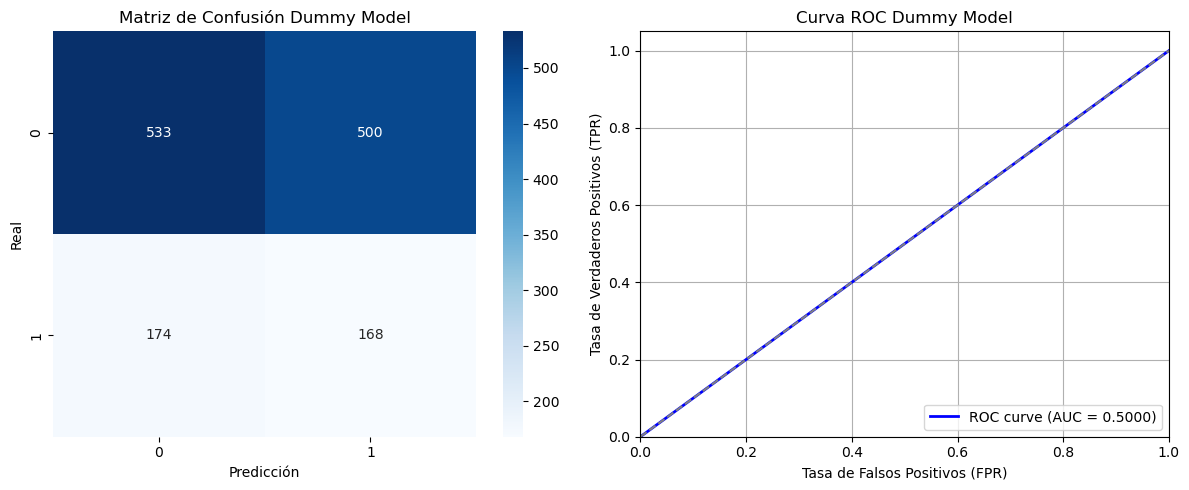

In [112]:
# Crear un clasificador Dummy 
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_train_resampled, y_train_resampled)

## Evaluación en conjunto de prueba
y_pred = dummy_model.predict(X_test)
y_proba = dummy_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Métricas en conjunto de prueba:")
print(f" AUC-ROC: {auc_roc:.4f}")
print(f" F1-score: {f1:.4f}")
print(f" Exactitud: {accuracy:.4f}")


# Crear una figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusión Dummy Model')

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC Dummy Model')
axes[1].legend(loc='lower right')
axes[1].grid()

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()


Tenemos un auc-roc de 0.5 y se muestra nuestra matriz de cofusion, esto es el modelo base para comparar el desempeño

### Busqueda de mejores hiperparametros con GridSearchCV

Con un grid de parametros a iterar y seleccionando aquellos con mayor influencia en los modelos, buscaremos la combinacion que alcance el mejor rendimineto evaluando principalmente por AUC-ROC.

In [116]:
# Definir el grid de parámetros
param_grid = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    'DecisionTreeClassifier': {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10]
    },
    'RandomForestClassifier': {
        'n_estimators': [ 50,100],
        'max_depth': [8, 10],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [ 5, 7, 10],
        'learning_rate': [ 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1]
    },
    'LGBMClassifier': {
        'n_estimators': [ 100, 200, 300],
        'max_depth': [-1, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 50]
    }
}

In [3198]:
# Grid con hiperparametros a iterar
param_grid_lgbm = {
        'n_estimators': [50, 100, 200],
        'max_depth': [-1, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [20, 31, 50]
    }

In [118]:
# Modelos a probar
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced'),
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'),
    'XGBClassifier': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'LGBMClassifier': LGBMClassifier()
}

# Definir métricas de evaluación
scoring = {
    'AUC': make_scorer(roc_auc_score, needs_proba=True),
    'F1': make_scorer(f1_score),
    'Accuracy': make_scorer(accuracy_score)
}

best_models = {}

# Grid Search con validación cruzada
for name, model in models.items():
    print(f"\n Optimizando {name}...")
    
    grid = GridSearchCV(model, param_grid[name], scoring=scoring, refit='AUC', 
                        cv=3, n_jobs=-1, verbose=1)
    
    grid.fit(X_train_resampled, y_train_resampled)
    
    best_models[name] = grid.best_estimator_
    
    print(f" Mejor modelo {name}: {grid.best_params_}")
    print(f" Mejor AUC-ROC: {grid.best_score_:.3f}")

D:\anaconda\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



 Optimizando LogisticRegression...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Mejor modelo LogisticRegression: {'C': 1, 'solver': 'liblinear'}
 Mejor AUC-ROC: 0.887

 Optimizando DecisionTreeClassifier...
Fitting 3 folds for each of 80 candidates, totalling 240 fits
 Mejor modelo DecisionTreeClassifier: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 20}
 Mejor AUC-ROC: 0.869

 Optimizando RandomForestClassifier...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
 Mejor modelo RandomForestClassifier: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
 Mejor AUC-ROC: 0.903

 Optimizando XGBClassifier...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:47:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Mejor modelo XGBClassifier: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
 Mejor AUC-ROC: 0.904

 Optimizando LGBMClassifier...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2271, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 6401, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354788 -> initscore=-0.598057
[LightGBM] [Info] Start training from score -0.598057
 Mejor modelo LGBMClassifier: {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 31}
 Mejor AUC-ROC: 0.904


Con esto GridSearchCV nos ha dado la combinaciones de hiperparametros con el mejor rendimiento haciendo validacion cruzada, ahora pasaremos al siguiente paso.

## Paso 4: Evaluacion de modelos

Con los hiperparametros con mejor rendimiento encontrados por GridSearchCV, probaremos cada modelo en el conjunto de datos de prueba y analizaremos dichos resultados, nos enfocaremos en AUC-ROC, ya que mide la capacidad del modelo para distinguir entre clases. También consideraremos el F1-score (balance entre precisión y recall) y la exactitud.



### Regresion Logistica


 Métricas en conjunto de prueba:
 AUC-ROC: 0.87
 F1-score: 0.65
 Exactitud: 0.79


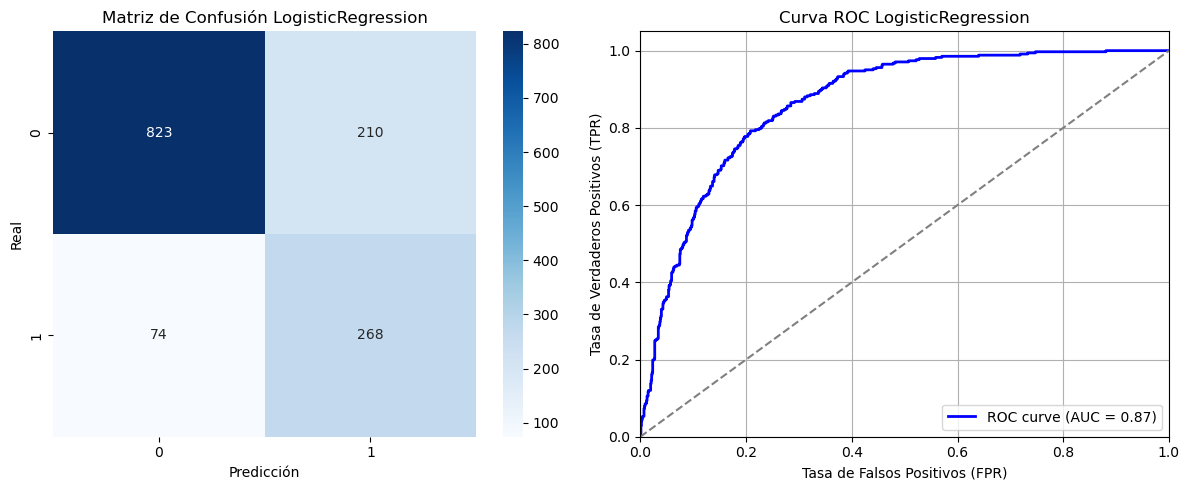

In [127]:
# Modelo de regresion logistica
lr_best = LogisticRegression(C=1, solver='liblinear', class_weight='balanced', random_state=123)
lr_best.fit(X_train_resampled, y_train_resampled)

## Evaluación en conjunto de prueba
y_pred = lr_best.predict(X_test)
y_proba = lr_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Métricas en conjunto de prueba:")
print(f" AUC-ROC: {auc_roc:.2f}")
print(f" F1-score: {f1:.2f}")
print(f" Exactitud: {accuracy:.2f}")


# Crear una figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusión LogisticRegression')

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC LogisticRegression')
axes[1].legend(loc='lower right')
axes[1].grid()

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()


* AUC-ROC: 0.87, lo que indica buena capacidad de clasificación.

* F1-score: 0.65, aceptable balance entre precisión y recall.

* Exactitud: 0.79, indica buen desempeño en la clasificación total.

* Errores: Relativamente bajos en FP (210) y FN (74).

### Arbol de Desicion


 Métricas en conjunto de prueba:
 AUC-ROC: 0.85
 F1-score: 0.63
 Exactitud: 0.77


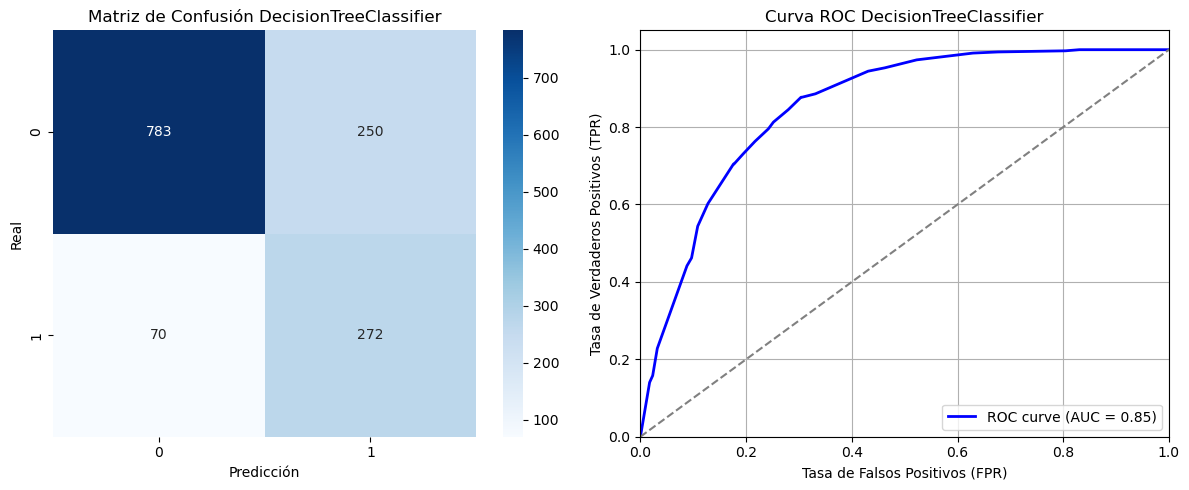

In [131]:
# modelo de arbol de decision
dt_best = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth= 5,
    min_samples_leaf= 2,
    min_samples_split= 20,
    random_state=123)
dt_best.fit(X_train_resampled, y_train_resampled)

## Evaluación en conjunto de prueba
y_pred = dt_best.predict(X_test)
y_proba = dt_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Métricas en conjunto de prueba:")
print(f" AUC-ROC: {auc_roc:.2f}")
print(f" F1-score: {f1:.2f}")
print(f" Exactitud: {accuracy:.2f}")


# Crear una figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusión DecisionTreeClassifier')

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC DecisionTreeClassifier')
axes[1].legend(loc='lower right')
axes[1].grid()

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()


* AUC-ROC: 0.85, mas bajo en comparacin de la regresion logistica.

* F1-score: 0.63, ligeramente peor que la regresión logística.

* Exactitud: 0.77, la más baja hasta ahora.

* Errores: Más Falsos Positivos (250), lo que indica que clasifica erróneamente más negativos como positivos.

### Bosque Aleatorio


 Métricas en conjunto de prueba:
 AUC-ROC: 0.88
 F1-score: 0.66
 Exactitud: 0.80


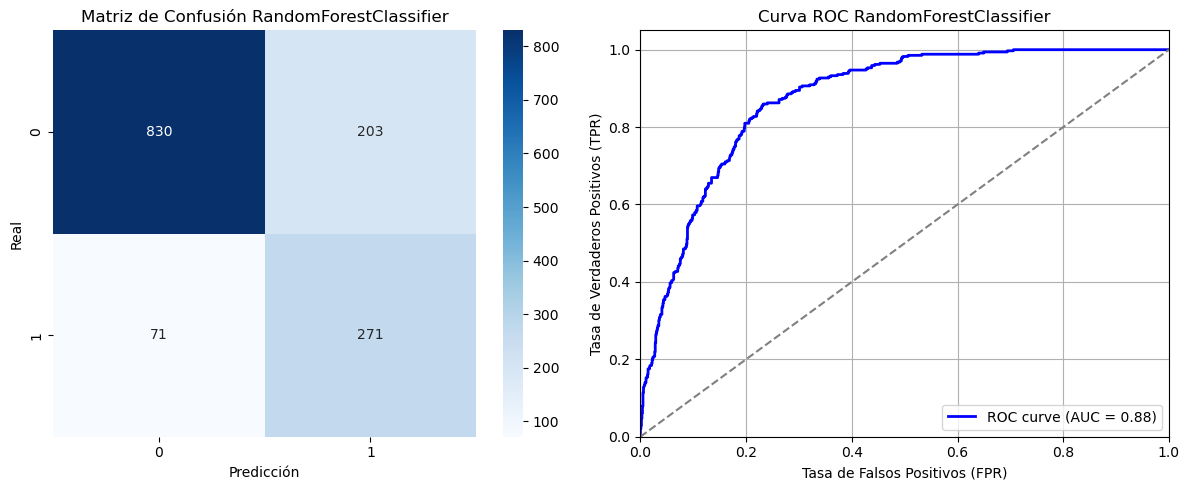

In [135]:
# modelo de bosque aleatorio
rf_best = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    max_depth = 10,
    min_samples_leaf= 1, 
    min_samples_split= 2,
    n_estimators= 50,
    random_state=123
)
rf_best.fit(X_train_resampled, y_train_resampled)

# Evaluación en conjunto de prueba
y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Métricas en conjunto de prueba:")
print(f" AUC-ROC: {auc_roc:.2f}")
print(f" F1-score: {f1:.2f}")
print(f" Exactitud: {accuracy:.2f}")


# Crear una figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusión RandomForestClassifier')

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC RandomForestClassifier')
axes[1].legend(loc='lower right')
axes[1].grid()

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()


* AUC-ROC: 0.88, el mejor valor entre los modelos anteriores.

* F1-score: 0.66, el más alto hasta este modelo.

* Exactitud: 0.80, ligeramente mejor que la regresión logística.

* Errores: Menos FP (203) y FN (71) en comparación con los otros modelos.

### Clasificador XGBoost


 Métricas en conjunto de prueba:
 AUC-ROC: 0.86
 F1-score: 0.60
 Exactitud: 0.80


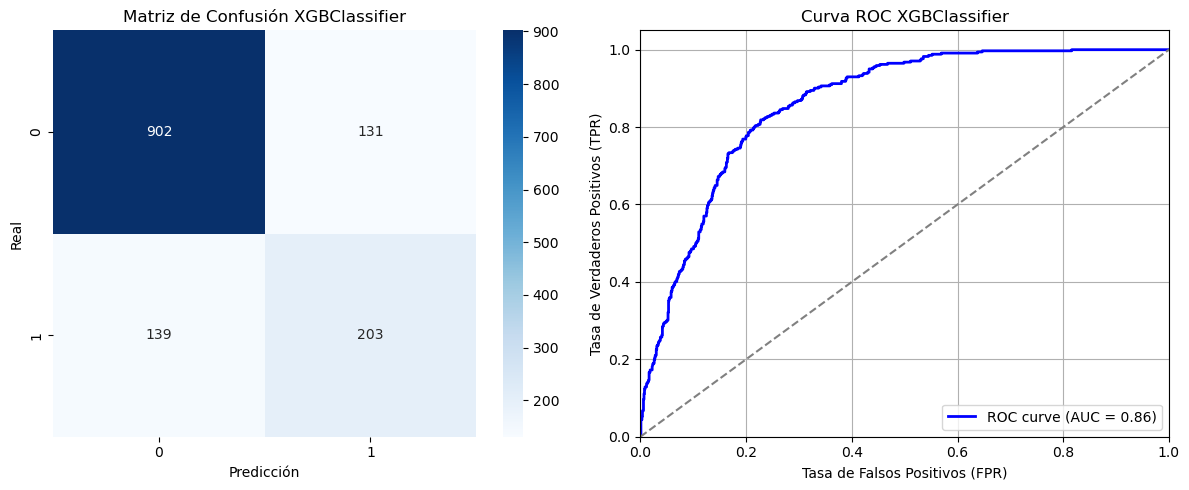

In [138]:
# modelo con implementacion de descenso de gradiente XGBoost
xgb_best = XGBClassifier(
    learning_rate= 0.1,
    max_depth= 7,
    n_estimators= 100, 
    subsample= 0.7,
    random_state=123
)
xgb_best.fit(X_train_resampled, y_train_resampled)

# Evaluación en conjunto de prueba
y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Métricas en conjunto de prueba:")
print(f" AUC-ROC: {auc_roc:.2f}")
print(f" F1-score: {f1:.2f}")
print(f" Exactitud: {accuracy:.2f}")


# Crear una figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusión XGBClassifier')

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC XGBClassifier')
axes[1].legend(loc='lower right')
axes[1].grid()

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()


* AUC-ROC: 0.86, menor que el bosque aleatorio y regresión logística.

* F1-score: 0.60, el más bajo, indicando problemas con el balance de clases.

* Exactitud: 0.80, igual que el bosque aleatorio.

* Errores: Muy pocos FP (131), pero muchos FN (139), lo que significa que falla en identificar correctamente la clase positiva.

### Clasificador LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2271, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 6401, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354788 -> initscore=-0.598057
[LightGBM] [Info] Start training from score -0.598057

 Métricas en conjunto de prueba:
 AUC-ROC: 0.87
 F1-score: 0.62
 Exactitud: 0.81


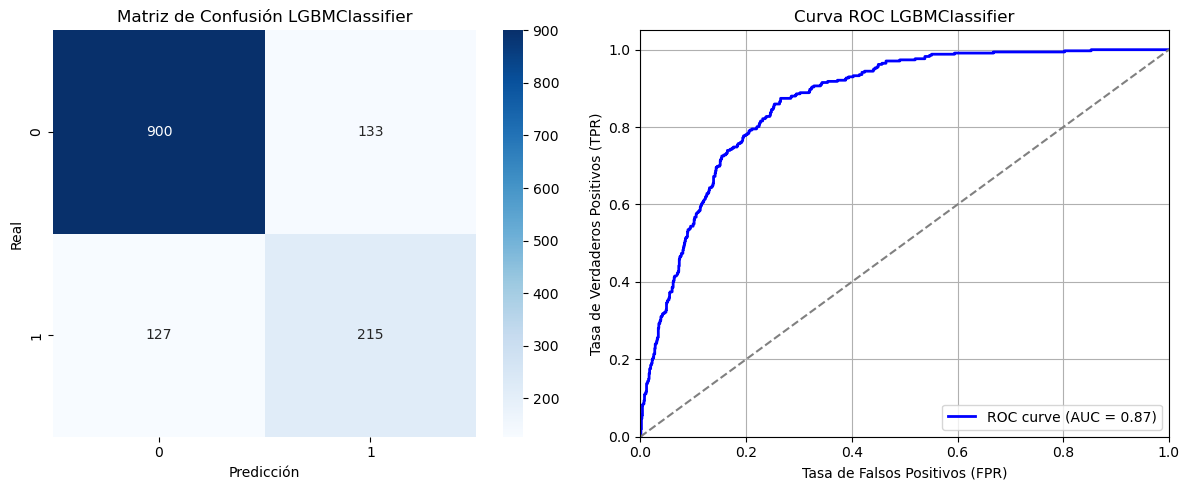

In [141]:
# modelo con implementacion de descenso de gradiente LightGBM
lgbm_best = LGBMClassifier(
    learning_rate=0.05,
    max_depth=15,
    n_estimators=200,
    num_leaves=31,
    random_state=123
)
lgbm_best.fit(X_train_resampled, y_train_resampled)

# Evaluación en conjunto de prueba
y_pred = lgbm_best.predict(X_test)
y_proba = lgbm_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Métricas en conjunto de prueba:")
print(f" AUC-ROC: {auc_roc:.2f}")
print(f" F1-score: {f1:.2f}")
print(f" Exactitud: {accuracy:.2f}")


# Crear una figura con dos subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusión LGBMClassifier')

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC LGBMClassifier')
axes[1].legend(loc='lower right')
axes[1].grid()

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()

* AUC-ROC: 0.87, similar a la regresión logística.

* F1-score: 0.62, mejor que XGBoost pero inferior al bosque aleatorio.

* Exactitud: 0.81, la mejor de todos los modelos.

* Errores: Muy pocos FP (133), pero más FN (127) que el bosque aleatorio.

### Conclusion General del paso 3 y 4. Busqueda de los mejores hiperparametro y la evaluacion de modelos

El bosque aleatorio es el mejor modelo con un AUC-ROC de 0.88 y el F1-score más alto (0.66). Además, tiene buen equilibrio entre FP y FN, lo que lo hace confiable para minimizar errores en ambas clases. Si se prefiere reducir los FP a costa de más FN, LGBM o XGBoost podrían ser opciones, pero el bosque aleatorio es el más equilibrado. 

## Paso 5: Conclusiones

El análisis de cancelación de clientes para Interconnect ha permitido identificar factores clave que influyen en la decisión de los clientes de cancelar el servicio. Con el preprocesamiento de datos, se corrigieron problemas de datos faltantes, desbalance de clases y outliers, asegurando así que los modelos de machine learning pudieran aprender patrones de cancelación de manera más efectiva.

El estudio reveló que las cancelaciones ocurren principalmente en los primeros meses del contrato, especialmente entre clientes con pagos mensuales elevados y métodos de pago menos comprometidos, como el cheque electrónico. Además, se observó que los contratos de mayor duración y los cargos totales acumulados son factores que reducen la probabilidad de cancelación.

En la fase de modelado, se probaron diversas técnicas y modelos, evaluados con métricas como AUC-ROC, F1-score y exactitud. El bosque aleatorio resultó ser el mejor modelo, con un AUC-ROC de 0.88, el mayor F1-score (0.66) y una exactitud de 0.80, logrando un equilibrio óptimo entre minimizar falsos positivos y falsos negativos. Este modelo permitirá a Interconnect identificar con mayor precisión a los clientes propensos a cancelar, facilitando la implementación de estrategias de retención, como ofertas personalizadas y promociones.

En conclusión, este proyecto proporciona un prototipo de modelo predictivo efectivo, basado en un análisis detallado de datos, que puede ser implementado para reducir la tasa de cancelación y mejorar la fidelización de clientes en Interconnect.

## Informe de solucion

En este informe de solucion, se le dara respuesta a las siguientes preguntas.

1.- ¿Que pasos del plan se realizaron y cuales se omitieron?

Todos los pasos se realizaron conforme a el plan de trabajo planteado en un inicio, cabe aclarar que estos si se vieron modificados ligeramente de acuerdo a las necesidades del proyecto, buscando mejorarlo y lograr resolver la tarea asignada. Por ejemplo, en la etapa de ingenieria de caracteristicas, no consideramos necesaria la escalarizacion de las variables continuas, pero al analizar el desbalance de clases, se profundizo mas de lo esperado, esto con el proposito de corregirlo optimamente, y, asi se mejoro significativamente la calidad de los datos.

2.- ¿Que dificultades se encontraron y como se lograron resolver?

La principal dificultad se encontro en la etapa de ingenieria de caracteristicas y fue el desbalance de clases. Si bien todas las etapas son importantes, esta etapa junto con el preprocesamiento de los datos, son la base con la cual se desarrollaron los modelos, y estos, por mas buenos que sean, y aun con la mejor combinacion de hiperparametros, si no se tiene un set de datos de calida, con suficientes datos y sin tanto ruido (por decir algunas caracteristicas), el rendimiento alcanzado por los modelos despues de entrenarlos no sera optimo, el rendimiento del modelo esta relacionado directamente con los datos con los que se entrena, por esto, saber manejar el desbalance de clases con diversas tecnicas como SMOTE, incluso, eliminando directamente observaciones que ocacionan ruido, fueron las acciones que dieron solucion a dicha dificultad, y estas acciones se fundamentaron con el entendimiento de nuestra tarea a resolver y la realizacion del EDA

3.- ¿Cuales fueron algunos de los pasos clave para resolver la tarea?

La realizacion de todos los pasos propuestos en el plan de trabajo fueron claves, ya que componian como se desarrollaria el proyecto en busqueda de resolver la tarea asignada, más sin embargo, las acciones que se llevaron a cabo en cada paso fueron cruziales, haciendo un enfasis en: el EDA para entender nuestos datos, como se relacionaban y como influian en nuestro objetivo a predecir(la cancelacion de un cliente), y el preprocesamiento de los datos con la ingenieria de caracteristicas, donde se manejaron los datos para obtener un dataset de calidad el cual maximizara el rendimiento de los modelos

4.- ¿Cual es el modelo final y que nivel de calidad tiene?

El modelo final es el Bosque Aleatorio, con un AUC-ROC de 0.88, F1-Score de 0.66 y una exactitud de 0.80, este pudo lograr un buen equilibrio entre minimizar falsos positivos y falsos negativos.